#### **Post Processing Notebook for Anomaly Detection**

**Tech Preamble**

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from matplotlib import colors
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [17]:
plt.rcParams.update({'font.size': 14})

**Select Region**

In [18]:
# region = "GS_new"
region = "Kuro_new_2"

**Load all Intervals**

In [19]:
lon = np.load(f"Data/lon_{region}.npy")
lat = np.load(f"Data/lat_{region}.npy")

intervals = [73] #[18, 24, 36, 54, 73]

time_int_spat_errors = {
    interval: np.load(
        f"/home/hmelzer/work/esn/CESM/{region}_new_anom_T_int{interval}/esn000/time_int_spat_error.npy"
    )
    for interval in intervals
}

Ntrain = 511

**Select Window Sizes**

In [20]:
window_configs = [(1, 1*73)]#, (6, 1*73), (18, 1*73), (1, 2*73), (6, 2*73), (18, 2*73), (1, 5*73), (6, 5*73), (18, 5*73)]# (1, 1*73), (2, 1*73), (2, 2*73), (3, 1*73), (6, 1*73), [(10, 73), (20, 73), (30, 73), (36, 73), (10, 2*73), (20, 2*73), (30, 2*73), (36, 2*73) ]
window_tags = { (sw, lw): f"sw_{sw}_lw_{lw}" for sw, lw in window_configs }

**Extract Statistical Fields (3D)**

In [21]:
import importlib
import esn_dev.anomaly
importlib.reload(esn_dev.anomaly)
from esn_dev.anomaly import *

In [22]:
# Allocate Dictionaries for all intervals
lw_mus_3d   = {interval: {} for interval in intervals}
lw_stds_3d  = {interval: {} for interval in intervals}
sw_mus_3d   = {interval: {} for interval in intervals}
window_tags = {interval: {} for interval in intervals}

for interval, error_data in time_int_spat_errors.items():
    for sw, lw in window_configs:
        tag = f"sw_{sw*5}_lw_{lw*5}"
        mu, std, smu = compute_window_stats(error_data, sw, lw)
        lw_mus_3d[interval][(sw, lw)]   = mu
        lw_stds_3d[interval][(sw, lw)]  = std
        sw_mus_3d[interval][(sw, lw)]   = smu
        window_tags[interval][(sw, lw)] = tag

In [23]:
max_std_steps = {}

for interval in intervals:
    max_std_steps[interval] = {}
    for (sw, lw), std_field in lw_stds_3d[interval].items():
        # reduce over space → time series
        std_timeseries = std_field.mean(axis=(1, 2))   # shape (time,)

        # index of max std
        max_std_steps[interval][(sw, lw)] = int(np.argmax(std_timeseries))


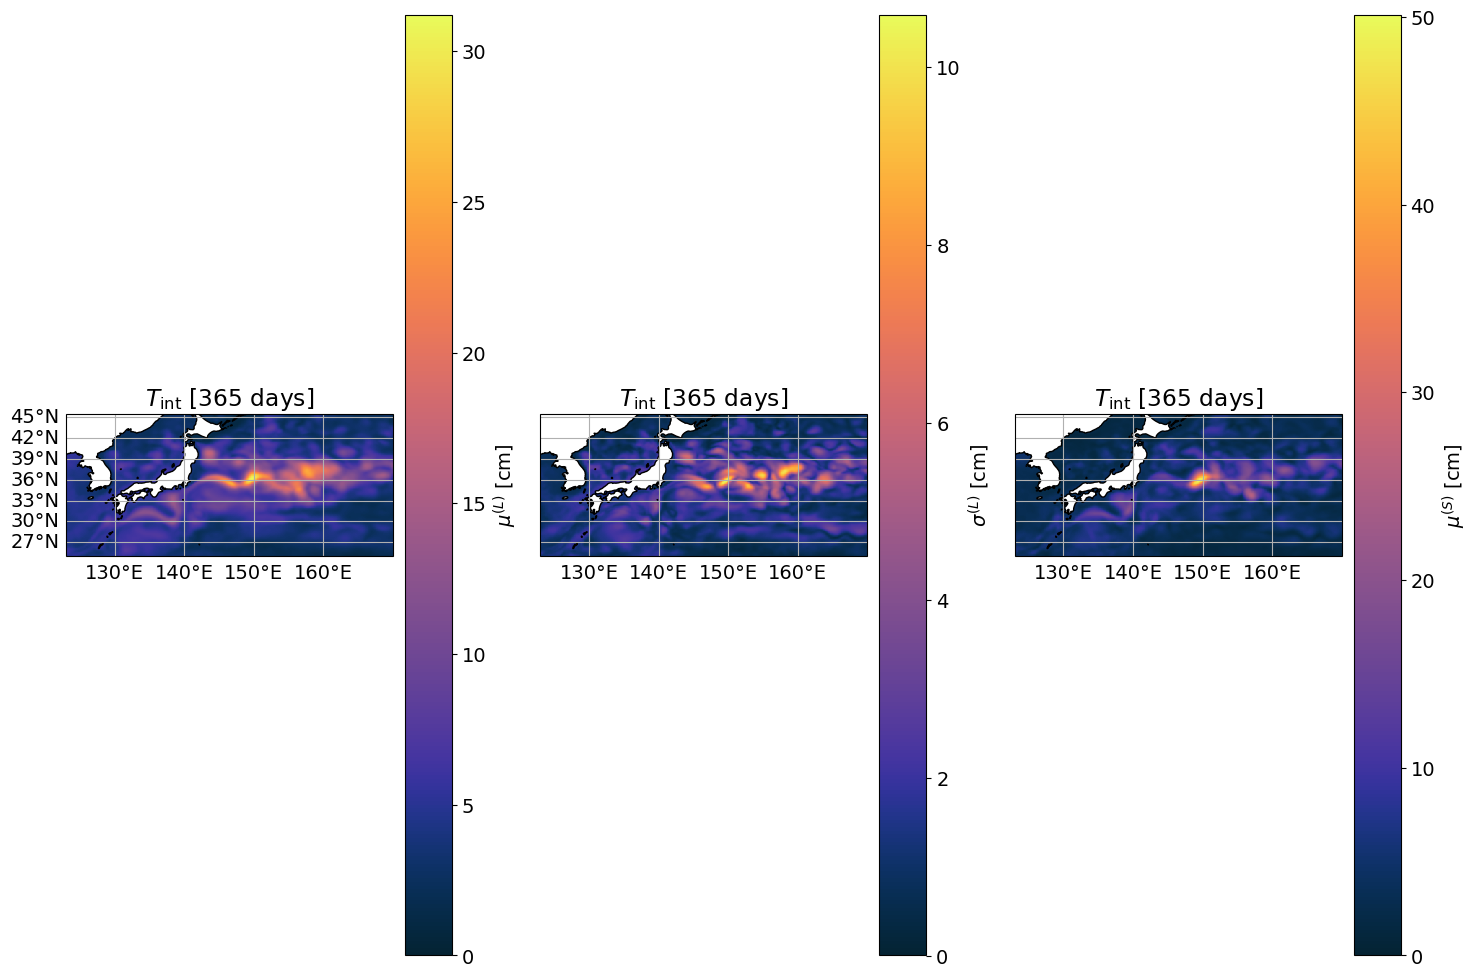

In [24]:
field_names = ["$\mu^{(L)}$ [cm]", "$\sigma^{(L)}$ [cm]", "$\mu^{(S)}$ [cm]"]
n_fields = len(field_names)
n_intervals = len(intervals)

for (sw, lw), tag in window_tags[intervals[0]].items():  # assuming same windows for all intervals
    fig, axes = plt.subplots(
        nrows=n_intervals,
        ncols=n_fields,
        figsize=(15, 10),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    # Ensure axes is 2D for consistent indexing
    if n_intervals == 1:
        axes = np.expand_dims(axes, axis=0)
    if n_fields == 1:
        axes = np.expand_dims(axes, axis=1)

    for row, interval in enumerate(intervals):
        # get the max timestep for this (sw, lw) at this interval
        i = max_std_steps[interval][(sw, lw)]

        # Extract fields for this interval
        mu_field  = lw_mus_3d[interval][(sw, lw)][i]
        std_field = lw_stds_3d[interval][(sw, lw)][i]
        smu_field = sw_mus_3d[interval][(sw, lw)][i]
        interval_fields = [mu_field, std_field, smu_field]

        for col, (field_data, name) in enumerate(zip(interval_fields, field_names)):
            ax = axes[row, col]

            pcm = ax.pcolormesh(lon, lat, field_data, shading="auto", cmap=cmocean.cm.thermal)
            ax.add_feature(cfeature.LAND, facecolor="white", zorder=1)
            ax.coastlines()
            ax.set_extent([lon.min() + 4, lon.max() - 2, lat.min() + 1, lat.max() - 5])
            gl = ax.gridlines(draw_labels=True)
            gl.top_labels = False
            gl.right_labels = False

            # remove x labels for all but the last row
            if row != n_intervals - 1:
                gl.bottom_labels = False

            # remove y labels for all but the first column
            if col != 0:
                gl.left_labels = False

            ax.set_title(f"$T_{{\\mathrm{{int}}}}$ [{interval * 5} days]")


            # Add individual colorbar for each subplot
            cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03)
            cbar.set_label(name)

    plt.tight_layout()
    plt.savefig(f"{region}_stat_sw{sw}_lw{lw}_int{intervals}.png", dpi=300, bbox_inches="tight")
    plt.show()


**Calculate Error and Anomaly Score** 

Identify a reasonable choice for std cutoff values from the plots above

In [25]:
manual_values_per_interval = {
    18: {"std_min": 1.5, "std_max": 2.3, "std_center": 1.5},
    24: {"std_min": 1.8, "std_max": 3, "std_center": 1.8},
    36: {"std_min": 2, "std_max": 3.5, "std_center": 2},
    54: {"std_min": 2.3, "std_max": 4.8, "std_center": 2.3},
    73: {"std_min": 2.3, "std_max": 5, "std_center": 2.3},
}

# Build the full dictionary
score_params_scaled = {}

for interval in intervals:
    score_params_scaled[interval] = {
        (sw, lw): manual_values_per_interval[interval]
        for (sw, lw) in window_configs
    }


In [26]:
scores_3d = {interval: {} for interval in intervals}
x_3d      = {interval: {} for interval in intervals}

for interval, error_data in time_int_spat_errors.items():
    for sw, lw in window_configs:
        mu  = lw_mus_3d[interval][(sw, lw)]
        std = lw_stds_3d[interval][(sw, lw)]
        smu = sw_mus_3d[interval][(sw, lw)]

        # Get interval-specific thresholds
        params = score_params_scaled[interval][(sw, lw)]

        scores, x = compute_sliding_score(
            error_data, mu, std, smu,
            std_min=params["std_min"],
            std_max=params["std_max"],
            std_center=params["std_center"],
        )
        scores_3d[interval][(sw, lw)] = scores
        x_3d[interval][(sw, lw)]      = x


In [27]:
interval_top_indices = {}

for interval in intervals:
    interval_indices = {}
    for (sw, lw), tag in window_tags[interval].items():
        sc = scores_3d[interval][(sw, lw)]

        # clip to avoid log(0)
        score_clipped = np.clip(sc, 1e-10, None)

        # compute -log(score)
        neg_log_score = -np.log(score_clipped)

        # sum over lon and lat
        spatial_sum = np.sum(neg_log_score, axis=(1, 2))

        # top N indices
        top_indices = np.argsort(spatial_sum)[-50:][::-1]

        interval_indices[(sw, lw)] = top_indices
    interval_top_indices[interval] = interval_indices


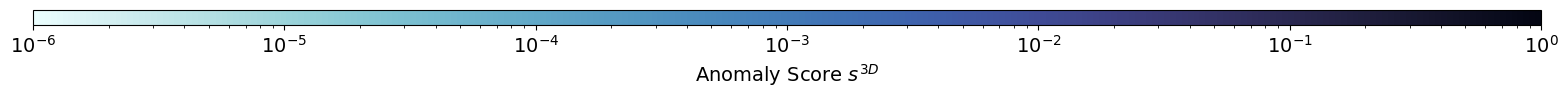

In [28]:
import math

score_min = 1e-6
score_max = 1
score_norm = colors.LogNorm(vmin=score_min, vmax=score_max)

# +1 so we reserve an extra slot for the colorbar
ncols = math.ceil((n_intervals + 1) / 2)
nrows = 2 if n_intervals > 1 else 1

for (sw, lw), tag in window_tags[intervals[0]].items():
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(15, 5),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    axes = np.atleast_1d(axes).ravel()

    # last slot is reserved for the colorbar
    cbar_ax = axes[-1]
    fig.delaxes(cbar_ax)  # delete it, but keep its space

    for i, interval in enumerate(intervals):
        score = scores_3d[interval][(sw, lw)]
        stack = np.stack([score[t] for t in top_indices])
        field_to_plot = np.min(stack, axis=0)

        ax = axes[i]
        pcm = ax.pcolormesh(
            lon, lat, field_to_plot,
            shading="auto", cmap=cmocean.cm.ice.reversed(),
            norm=score_norm, transform=ccrs.PlateCarree()
        )

        ax.add_feature(cfeature.LAND, facecolor="white", zorder=1)
        ax.coastlines()
        ax.set_extent(
            [lon.min() + 4, lon.max() - 2, lat.min() + 1, lat.max() - 5],
            crs=ccrs.PlateCarree()
        )

        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.right_labels = False
        if i % ncols != 0:
            gl.left_labels = False

        ax.set_title(f"$T_{{\\mathrm{{int}}}}$ [{interval*5} days]")

    # now reuse that empty slot for the colorbar
    pos = axes[-1].get_position()   # get position of the deleted subplot
    cbar_ax = fig.add_axes([pos.x0-pos.width/2+0.025, pos.y0+0.2, pos.width*1.5, 0.03])  # same width, small height
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Anomaly Score $s^{3D}$")

    plt.savefig(f"scores_only_sw{sw}_lw{lw}_int{intervals}.png", dpi=300, bbox_inches="tight")
    plt.show()


**Create Mask**

Based on Anomaly Score

In [29]:
masks_by_interval = {}

for interval in intervals:
    interval_masks = {}

    # loop over (sw, lw) pairs for this interval
    for (sw, lw), tag in window_tags[interval].items():
        sc = scores_3d[interval][(sw, lw)]

        # get the top indices for this interval/(sw, lw)
        top_indices = interval_top_indices[interval][(sw, lw)]

        # select only those scores
        top_sc = sc[top_indices]

        # build mask
        mask_2d = np.any(top_sc <= 1e-2, axis=0)

        interval_masks[(sw, lw)] = mask_2d

    masks_by_interval[interval] = interval_masks


**Plot Mask**

Split Mask - optional/ for Kuroshio

In [30]:
masks_berlin = {interval: {} for interval in intervals}

for interval, error_data in time_int_spat_errors.items():
    for sw, lw in window_configs:
        # base mask for this interval & (sw, lw)
        mask_2d = masks_by_interval[interval][(sw, lw)]  # <-- replace with your mask source

        # East of 140E
        mask_east = mask_2d & (lon > 142)

        # West of 140E
        mask_west = mask_2d & (lon <= 142)

        # store both under current (sw, lw)
        masks_berlin[interval][(sw, lw)] = {
            "mask_east": mask_east,
            "mask_west": mask_west,
        }


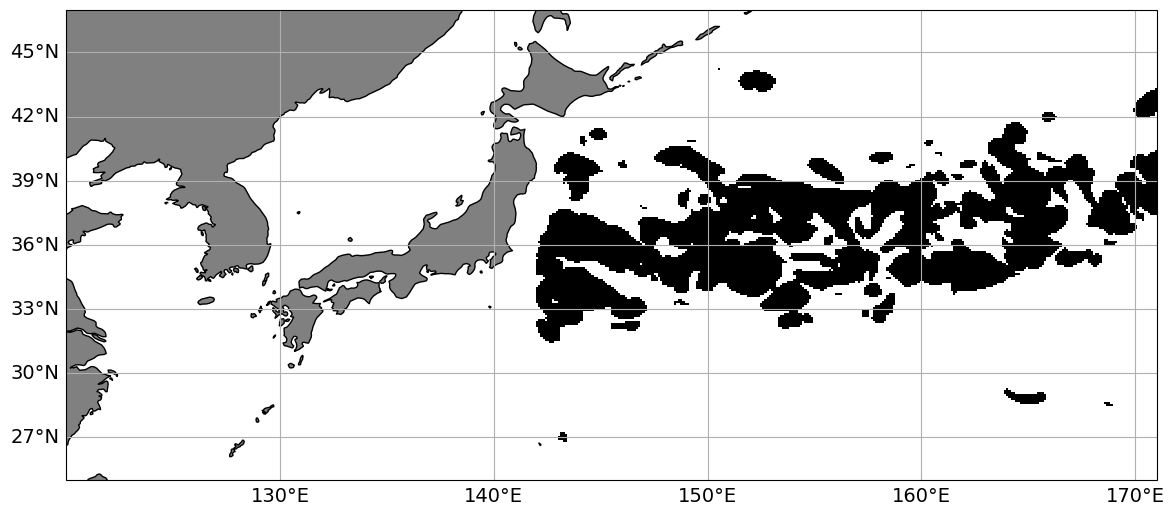

In [44]:
for interval in intervals:
    for (sw, lw), tag in window_tags[interval].items():
        mask_2d = masks_berlin[interval][(sw, lw)]["mask_east"]

        fig = plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.PlateCarree())

        pcm = ax.pcolormesh(lon, lat, mask_2d,
                            shading='auto',
                            cmap="binary",
                            transform=ccrs.PlateCarree())

        # Add features
        ax.add_feature(cfeature.LAND, facecolor='gray', zorder=1)
        ax.coastlines()
        ax.set_extent([lon.min() + 1, lon.max() - 1,
                       lat.min() + 1, lat.max() - 1], crs=ccrs.PlateCarree())

        # Gridlines
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.right_labels = False

        # Colorbar and title
        # plt.colorbar(pcm, ax=ax, orientation='vertical', label='Mask')
        # ax.set_title(f"Mask ({tag}) - Interval {interval}")

        plt.tight_layout()
        plt.savefig(f"Mask_{region}_east_{tag}_interval{interval}.png", dpi=300)
        # plt.close(fig)  # close to free memory

**Select Subregion to perform Anomaly Detection on**

Select Area of mask

In [32]:
# Dictionary to store the time-space scalar errors
time_space_scalar_errors = {}

for interval in intervals:
    # Full 3D error array for this interval
    time_int_spat_error_og = time_int_spat_errors[interval]  # shape: (time, lat, lon)

    scalar_errors_per_window = {}
    for (sw, lw), tag in window_tags[interval].items():
        # Get the 2D mask for this interval and (sw, lw)
        mask_2d = masks_by_interval[interval][(sw, lw)]

        # Apply the mask (flattened spatial selection)
        masked_error = time_int_spat_error_og[:, mask_2d]

        # Sum over space to get scalar error per timestep
        time_space_int_scalar_error = masked_error.sum(axis=1)

        scalar_errors_per_window[(sw, lw)] = time_space_int_scalar_error

    time_space_scalar_errors[interval] = scalar_errors_per_window


Choose more window sizes

In [33]:
# window_configs = [(1, 1*73)]#, (2, 1*73), (2, 2*73), (3, 1*73), (6, 1*73)]


# Define tags based on window configs
# window_tags = { (sw, lw): f"sw_{sw}_lw_{lw}" for sw, lw in window_configs }

Calculate Anomaly Score

In [34]:
# Dictionaries to store results per interval
anom_scores_by_interval = {}
lw_mus_by_interval = {}
lw_stds_by_interval = {}
sw_mus_by_interval = {}
x_s_by_interval = {}

for interval in intervals:
    # Initialize dictionaries for this interval
    anom_scores = {}
    lw_mus = {}
    lw_stds = {}
    sw_mus = {}
    x_s = {}

    # Loop over each (sw, lw) pair
    for sw, lw in window_configs:
        # tag = f"sw_{sw*5}_lw_{lw*5}"
        
        # Get the time-space scalar error for this window
        time_space_error = time_space_scalar_errors[interval][(sw, lw)]

        # Compute sliding score
        score, mu, std, smu, x = sliding_score_1D(time_space_error, sw, lw)

        # Store results
        anom_scores[(sw, lw)] = score
        lw_mus[(sw, lw)] = mu
        lw_stds[(sw, lw)] = std
        sw_mus[(sw, lw)] = smu
        x_s[(sw, lw)] = x
        window_tags[interval][(sw, lw)] = tag  # update tags per interval

    # Save per-interval dictionaries
    anom_scores_by_interval[interval] = anom_scores
    lw_mus_by_interval[interval] = lw_mus
    lw_stds_by_interval[interval] = lw_stds
    sw_mus_by_interval[interval] = sw_mus
    x_s_by_interval[interval] = x_s


**Plot**

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def anom_score_plot_windows_scalar_5x1(
    anom_scores_by_interval, Ntrain, intervals, top_indices_by_interval=None, savepath=None
):
    """
    Plot anomaly scores for each interval in a single figure with stacked subplots.
    Each subplot shows all (sw, lw) windows with a consistent color/linestyle scheme.
    Only the last subplot shows the x-axis labels and the legend.

    Linestyle distinguishes individual members, color distinguishes window groups.
    """
    # --- color/linestyle scheme ---
    cmap = plt.get_cmap("tab10")
    colors = [cmap(0), cmap(1), cmap(2)]    # blue, orange, green
    linestyles = ["-", "--", ":"]           # solid, dashed, dotted

    fig, axes = plt.subplots(
        nrows=len(intervals), ncols=1,
        figsize=(12, 3*len(intervals)),
        sharex=True
    )

    if len(intervals) == 1:
        axes = [axes]

    # --- determine common x-ticks/labels ---
    max_len = max(len(score) for interval in intervals
                               for score in anom_scores_by_interval[interval].values())
    time_steps = np.arange(max_len)
    full_labels = (Ntrain + time_steps) * 5  # time in days

    span = full_labels[-1] - full_labels[0]
    step = 500 if span <= 5000 else 1000
    start = ((full_labels[0] // step) + 1) * step
    end = (full_labels[-1] // step) * step
    common_labels = np.arange(start, end + 1, step)
    common_ticks = (common_labels // 5) - Ntrain

    for idx, (ax, interval) in enumerate(zip(axes, intervals)):
        all_windows = list(anom_scores_by_interval[interval].keys())
        n_colors = len(colors)
        n_linestyles = len(linestyles)

        for i, (sw, lw) in enumerate(all_windows):
            score = anom_scores_by_interval[interval][(sw, lw)]

            color = colors[i // n_linestyles % n_colors]      # switch color every n_linestyles
            linestyle = linestyles[i % n_linestyles]         # cycle linestyles

            ax.plot(
                score,
                color=color,
                linestyle=linestyle,
                label=f"sw={sw*5}, lw={lw*5}",
                linewidth=1.8
            )

            if top_indices_by_interval is not None:
                top_idx = top_indices_by_interval[interval][(sw, lw)]
                y_min, y_max = ax.get_ylim()
                y_pos = y_max * 1.05
                ax.plot(top_idx, [y_pos]*len(top_idx), 'k*')

        ax.set_yscale('log')
        ax.set_ylabel('Anomaly Score $s^{1D}$')
        ax.grid(True, linestyle=':', linewidth=0.6)
        ax.set_title(f"Integration Interval $T_{{\\mathrm{{int}}}}$ = {interval*5} [days]")

        # apply common ticks
        ax.set_xticks(common_ticks)
        ax.set_xticklabels(common_labels)

        if idx < len(axes) - 1:
            ax.set_xticklabels([])
            ax.set_xlabel("")
        else:
            ax.set_xlabel('Time [days]')
            ax.legend(frameon=False, fontsize=10, loc="lower left", ncol=3)

    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=300, bbox_inches='tight')

    return fig

In [36]:
# figs = anom_score_plot_windows_scalar(anom_scores_by_interval, Ntrain, intervals)
# figs = anom_score_plot_windows_scalar_5x1(anom_scores_by_interval, Ntrain, intervals, savepath=f"{region}_anom_scores_1x5.png")

**East**

In [37]:
# Dictionary to store the time-space scalar errors
time_space_scalar_errors_east = {}

for interval in intervals:
    # Full 3D error array for this interval
    time_int_spat_error_og = time_int_spat_errors[interval]  # shape: (time, lat, lon)

    scalar_errors_per_window = {}
    for (sw, lw), tag in window_tags[interval].items():
        # Get the 2D mask for this interval and (sw, lw)
        mask_2d = masks_berlin[interval][(sw, lw)]["mask_east"]

        # Apply the mask (flattened spatial selection)
        masked_error = time_int_spat_error_og[:, mask_2d]

        # Sum over space to get scalar error per timestep
        time_space_int_scalar_error = masked_error.sum(axis=1)

        scalar_errors_per_window[(sw, lw)] = time_space_int_scalar_error

    time_space_scalar_errors_east[interval] = scalar_errors_per_window

In [38]:

anom_scores_by_interval_east = {}
# lw_mus_by_interval = {}
# lw_stds_by_interval = {}
# sw_mus_by_interval = {}
# x_s_by_interval = {}

for interval in intervals:
    # Initialize dictionaries for this interval
    anom_scores = {}
    lw_mus = {}
    lw_stds = {}
    sw_mus = {}
    x_s = {}

    # Loop over each (sw, lw) pair
    for sw, lw in window_configs:
        # tag = f"sw_{sw*5}_lw_{lw*5}"
        
        # Get the time-space scalar error for this window
        time_space_error = time_space_scalar_errors_east[interval][(sw, lw)]

        # Compute sliding score
        score, mu, std, smu, x = sliding_score_1D(time_space_error, sw, lw)

        # Store results
        anom_scores[(sw, lw)] = score
        lw_mus[(sw, lw)] = mu
        lw_stds[(sw, lw)] = std
        sw_mus[(sw, lw)] = smu
        x_s[(sw, lw)] = x
        window_tags[interval][(sw, lw)] = tag  # update tags per interval

    # Save per-interval dictionaries
    anom_scores_by_interval_east[interval] = anom_scores
    # lw_mus_by_interval[interval] = lw_mus
    # lw_stds_by_interval[interval] = lw_stds
    # sw_mus_by_interval[interval] = sw_mus
    # x_s_by_interval[interval] = x_s


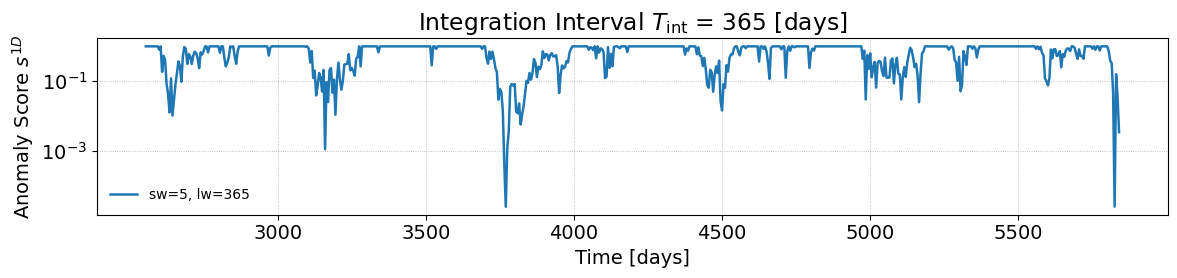

In [39]:
# figs = anom_score_plot_windows_scalar(anom_scores_by_interval_east, Ntrain, intervals)
figs = anom_score_plot_windows_scalar_5x1(anom_scores_by_interval_east, Ntrain, intervals, savepath=f"{region}_east_anom_scores_1x5.png")

**West**

In [40]:
# Dictionary to store the time-space scalar errors
time_space_scalar_errors_west = {}

for interval in intervals:
    # Full 3D error array for this interval
    time_int_spat_error_og = time_int_spat_errors[interval]  # shape: (time, lat, lon)

    scalar_errors_per_window = {}
    for (sw, lw), tag in window_tags[interval].items():
        # Get the 2D mask for this interval and (sw, lw)
        mask_2d = masks_berlin[interval][(sw, lw)]["mask_west"]

        # Apply the mask (flattened spatial selection)
        masked_error = time_int_spat_error_og[:, mask_2d]

        # Sum over space to get scalar error per timestep
        time_space_int_scalar_error = masked_error.sum(axis=1)

        scalar_errors_per_window[(sw, lw)] = time_space_int_scalar_error

    time_space_scalar_errors_west[interval] = scalar_errors_per_window

In [41]:

anom_scores_by_interval_west = {}
# lw_mus_by_interval = {}
# lw_stds_by_interval = {}
# sw_mus_by_interval = {}
# x_s_by_interval = {}

for interval in intervals:
    # Initialize dictionaries for this interval
    anom_scores = {}
    lw_mus = {}
    lw_stds = {}
    sw_mus = {}
    x_s = {}

    # Loop over each (sw, lw) pair
    for sw, lw in window_configs:
        # tag = f"sw_{sw*5}_lw_{lw*5}"
        
        # Get the time-space scalar error for this window
        time_space_error = time_space_scalar_errors_west[interval][(sw, lw)]

        # Compute sliding score
        score, mu, std, smu, x = sliding_score_1D(time_space_error, sw, lw)

        # Store results
        anom_scores[(sw, lw)] = score
        lw_mus[(sw, lw)] = mu
        lw_stds[(sw, lw)] = std
        sw_mus[(sw, lw)] = smu
        x_s[(sw, lw)] = x
        window_tags[interval][(sw, lw)] = tag  # update tags per interval

    # Save per-interval dictionaries
    anom_scores_by_interval_west[interval] = anom_scores
    # lw_mus_by_interval[interval] = lw_mus
    # lw_stds_by_interval[interval] = lw_stds
    # sw_mus_by_interval[interval] = sw_mus
    # x_s_by_interval[interval] = x_s


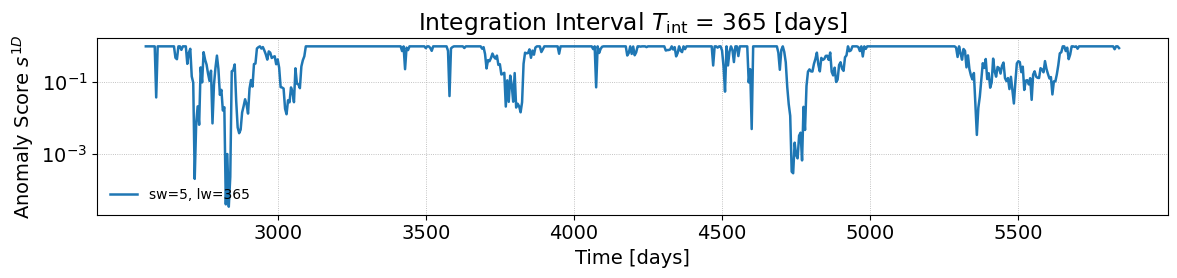

In [42]:
# figs = anom_score_plot_windows_scalar(anom_scores_by_interval_west, Ntrain, intervals)
figs = anom_score_plot_windows_scalar_5x1(anom_scores_by_interval_west, Ntrain, intervals, savepath=f"{region}_west_anom_scores_1x5.png")